In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import csv
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy

#import torch
#import torch.nn as nn
#import torch.nn.parallel
#import torch.optim as optim
#import torch.utils.data

#from torch.nn import functional
#from torch.autograd import Variable

import statistics

#temporal pattern clustering
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

#regression model
from patsy import dmatrices
#import statsmodels.api as sm

from datetime import datetime

#from pysal.model import spreg
#from pysal.lib import weights
#from pysal.explore import esda

#calculate the demographic bias 
#use wasserstein_distance
from scipy.stats import wasserstein_distance

#path = 'C:/Users/29700/Downloads/RecSys-Workshop/tutorials/'
#os.chdir(path)
#import utilities as utl

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mae
from datetime import datetime
import time
from sklearn.decomposition import NMF

import time
import scipy.sparse
from scipy.stats import entropy
from sys import exit

import itertools
from itertools import permutations

import xml.etree.ElementTree as ET

import geopandas as gpd

In [5]:
input_path = 'G:/My Drive/2021/Bias/SUMO_simulation/appsim/'
os.chdir(input_path)

In [20]:
def get_time_variationbyzone(data, taz, time_loc, plot_index):
    data_taz = data[data['taz']==taz]
    data_taz = data_taz.sort_values(by=['hr', 'min'])
    data_taz = data_taz.groupby(by=['hr', 'min']).sum()
    
    data_taz.reset_index(inplace=True)
    data_taz = data_taz[['hr','min','sum']]
    #data_taz
    obs_sum = np.zeros((len(time_loc)))
    hr_ = data_taz['hr'].values
    min_ = data_taz['min'].values
    sum_val = data_taz['sum'].values
    
    for i in range(len(hr_)):
        obs_sum[time_loc[str(hr_[i])+'_'+str(min_[i])]] = sum_val[i]
    #use obs/max(obs) instead of obs/sum(obs) 
    obs_per = obs_sum/(np.max(obs_sum))
    
    if plot_index == True:
        fig = plt.figure(taz)
        plt.plot(obs_sum)
    return(obs_per)

def get_sim_obs_ts(fcd_out, taz_time_per, avg_per, return_sim=True):
    taz_ = fcd_out['taz'].values
    time_5 = fcd_out['time_5'].values
    per_ts = []
    for i in range(len(taz_)):
        if taz_[i] in taz_time_per:
            per_ts.append(taz_time_per[taz_[i]][time_5[i]])
        else:
            per_ts.append(avg_per[time_5[i]])
    if return_sim == True:
        sim_obs_ts = [] 
        for i in range(len(per_ts)):
            sim_obs_ts.append(np.random.binomial(1, per_ts[i], 1)[0])
        return(sim_obs_ts)
    else:
        return(per_ts)
    

#convert dt to matrix
def read_fcd(fcd_dt_path, app_based_data):
    fcd_out = pd.read_csv(fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']
    fcd_out.taz = fcd_out.taz.astype('int')
    
    
    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3
    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    
    fcd_out['time'] = fcd_out['time'].astype('int')
    fcd_out['hr'] = (fcd_out['time'].values/3600).astype(int)
    fcd_out['minus'] = ((fcd_out['time'].values- fcd_out['hr'].values*3600)/60).astype(int)
    fcd_out['time_30'] = (fcd_out['time']/30).astype(int)
    fcd_out['time_5'] = (fcd_out['time']/300).astype(int)
    
    print('num id', len(np.unique(fcd_out.reids)))

    #fcd_out.sort_values(by=['time', 'taz'])
    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+(fcd_out['time_5']).astype(str)

    time_ = np.unique((fcd_out['time']/300).astype(int))
    
    if app_based_data == True:
        #sample index 0: non app-based samples, 1: app=based samples, 3: transit
        #fcd_out.groupby(by=['sample_index']).size()
        #sample_index 0    1714901, 1     572267, 3     180802
        return(fcd_out[fcd_out['sample_index']!=0])
    else:
        return(fcd_out)
    
def getfcdnorigindt(fcd_out, savepath, 
                    data_obs, time_loc, taz_time_per, avg_per, 
                    save_index):
    #get one day data (use 5 min as the time interval)
    #fcd_out = fcd_out[fcd_out['time_5']<288]
    newuser_ = {}
    index_ = 0
    for i in np.unique(fcd_out.reids):
        newuser_[i] = index_
        index_ += 1    
    ## fcd output processing
    #delete the data exceeds the 24-hr daily period
    #fcd_out = fcd_out[~fcd_out['time'].isin([86400, 86700])]
    fcd_out.time = fcd_out.time.astype('int')

    obs = data_obs.groupby(by=['time']).size().values
    obs_per = obs/max(obs)

    sample_ct = lambda x: np.random.binomial(1, obs_per[x], 1)[0]

    fcd_out['sim_obs'] = fcd_out['time_5'].apply(sample_ct)

    fcd_out['tl_id'] = fcd_out['taz'].astype(str)+'_'+((fcd_out['time']/300).astype(int)).astype(str)
    
    sim_obs = get_sim_obs_ts(fcd_out, taz_time_per, avg_per, True)
    fcd_out['sim_obs_ts'] = sim_obs

    #simulated observations based on time variation
    print('sim based on time', 
          np.count_nonzero(fcd_out['sim_obs'])/fcd_out.shape[0])

    #simulated observations based on time and spatial variation
    print('sim based on time and spatial',
          np.count_nonzero(fcd_out['sim_obs_ts'])/fcd_out.shape[0])
    
    return(fcd_out)

#fcd_out = read_fcd(fcd_dt_path, app_based_data)
def run_sim(csv_path, fcd_out, savepath, save_index=False, plot_index=True):
    data_obs = pd.read_csv(csv_path, header=0)
    print('app based data', data_obs.head(3))
    
    newids = np.unique(data_obs.newid)
    newid_ = {}
    index_ = 0
    for i in range(len(newids)):
        newid_[newids[i]] = index_
        index_ += 1
        
    get_hr = lambda x: x.split(':')[0]
    get_min = lambda x: x.split(':')[1]

    hr_ = np.unique(data_obs['time'].astype(str).apply(get_hr).astype(int))
    min_ = np.unique(data_obs['time'].astype(str).apply(get_min).astype(int))
    taz_ = np.unique(data_obs['taz'])

    data_obs['hr'] = data_obs['time'].astype(str).apply(get_hr).astype(int)
    data_obs['min'] = data_obs['time'].astype(str).apply(get_min).astype(int)
    
    index_ = 0
    lt_loc = {}
    for taz in taz_:
        for h in hr_:
            for m in min_:
                lt_loc['4_'+str(h)+'_'+str(m)+'_'+str(taz)] = index_
                index_ += 1
    obs_mx = np.zeros((len(newid_), len(lt_loc)))

    newid_col = data_obs.newid.values
    key_col = data_obs.key.values
    ct_col = data_obs['sum'].values

    for i in range(len(newid_col)):
        obs_mx[newid_[newid_col[i]]][lt_loc[key_col[i]]] = 1

    total_ct = np.sum(obs_mx, axis=0)
    #get ct based on taz and time
    total_ct = total_ct.reshape(1, total_ct.shape[0])
    total_ct_conver = np.hsplit(total_ct, len(taz_))
    max_num = np.max(np.array(total_ct_conver), axis=2)
    
    if plot_index == True:
        plt.plot(data_obs.groupby(by=['time']).size().values)
        
    time_loc = {}
    index_ = 0
    for hr in hr_:
        for miuts in min_:
            time_loc[str(hr)+'_'+str(miuts)] = index_
            index_ += 1

    taz_time_per = {}
    avg_per = 0
    index_ = 0 
    for taz_id in taz_:
        taz_time_per[taz_id] = get_time_variationbyzone(data_obs, taz_id, time_loc, plot_index)
        if index_ == 0:
            avg_per = taz_time_per[taz_id]
        else:
            avg_per = avg_per + taz_time_per[taz_id]
        index_ += 1
        
    avg_per = avg_per/np.max(avg_per)
    if plot_index == True:
        fig = plt.figure(1)
        plt.plot(avg_per)
        
    
    fcd_out = getfcdnorigindt(fcd_out, savepath, data_obs, time_loc, taz_time_per, avg_per, save_index=False)
    
    fcd_out['obs'] = 1
    #simulation compare
    print('sim_t vs sim_ts', mean_squared_error(fcd_out.sim_obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_ts', mean_squared_error(fcd_out.obs, fcd_out.sim_obs_ts, squared=False))
    print('obs vs sim_t', mean_squared_error(fcd_out.obs, fcd_out.sim_obs, squared=False))
    
    return(fcd_out)   

def get_timeloc(num_taz, time_interval, t):
    select_time_loc = []
    for i in range(num_taz):
        select_time_loc.append(time_interval*i+t)
    return(select_time_loc)

def get_pred_timedict(num_taz, time_interval):
    pred_time_loc = {}
    for t in range(time_interval):
        select_time_loc = get_timeloc(num_taz, time_interval, t)
        pred_time_loc[t] = select_time_loc
    return(pred_time_loc)

def get_maxvalnindex(WHpert):
    max_val = np.max(WHpert, axis=1)
    max_index = np.argmax(WHpert, axis=1)
    return(max_val, max_index)

def get_pred_dt(WH_pred, time_interval):
    num_taz = int(WH_pred.shape[1]/time_interval)
    print('num taz', num_taz)
    pred_time_dic = get_pred_timedict(num_taz, time_interval)
    for t in pred_time_dic:
        pred_val = WH_pred[:, pred_time_dic[t]]
        if t == 0:
            max_val, max_index = get_maxvalnindex(pred_val)
        else:
            max_val_cur, max_index_cur = get_maxvalnindex(pred_val)
            max_val = np.vstack((max_val, max_val_cur))
            max_index = np.vstack((max_index, max_index_cur))
    return(max_val.T, max_index.T)  


def get_simdt(fcd_out, sim_col, newuser_, loc_time):
    sim_dt = np.zeros((len(newuser_), len(loc_time)))
    fcd_obs = fcd_out[['reids', 'tl_id', 'sim_obs']].groupby(by=['reids', 'tl_id']).sum()
    fcd_obs.reset_index(inplace=True) 
    ids_ = fcd_obs['reids'].values
    tl_id_ = fcd_obs['tl_id'].values
    sim_obs = fcd_obs['sim_obs'].values
    for i in range(len(ids_)):
        sim_dt[newuser_[ids_[i]]][loc_time[tl_id_[i]]] = sim_obs[i]
    return(sim_dt)

def fit_dt(fcd_out, sim_col, newuser_, loc_time, k_val): 
    sim_dt = get_simdt(fcd_out, sim_col, newuser_, loc_time)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def get_index_lst(i, num_taz, num_time):
    return(list(np.arange(i, (num_time-1)*num_taz+i, num_time)))

#sep_dict = {'mor':[6, 9]
#            'noon':[9, 17]
#            'eve':[17, 20]}
def sep_indexdetime(num_taz, num_time, time_interval):
    sep_time = {'mor':[],
               'noon':[],
               'eve':[],
               'other':[]}
    for i in range(num_time):
        if i>=6*time_interval and i < 9*time_interval:
            sep_time['mor'].extend(get_index_lst(i, num_taz, num_time))
        elif i >= 9*time_interval and i < 17*time_interval:
            sep_time['noon'].extend(get_index_lst(i, num_taz, num_time))
        elif i>17*time_interval and i <20*time_interval:
            sep_time['eve'].extend(get_index_lst(i, num_taz, num_time))
        else:
            sep_time['other'].extend(get_index_lst(i, num_taz, num_time))
            
    for key in sep_time:
        sep_time[key] = sorted(sep_time[key])
    return(sep_time)

def fit_dtbytime(sim_dt, num_taz, num_time, time_interval, k_val, save_name):
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index'+ky+'_'+save_name+'.csv')

def del_transit_oneobs(fcd_out):
    fcd_transit = fcd_out[fcd_out['sample_index']==3]
    fcd_transit = fcd_transit.groupby(by=['id']).size().to_frame()
    fcd_transit.reset_index(inplace=True)
    fcd_transit_ids = fcd_transit[['id']][fcd_transit[0]==1].values.flatten()
    #print(fcd_transit_ids)
    print('# o ftransit line with only one obs deleted', len(fcd_transit_ids))
    return(fcd_out[~fcd_out['id'].isin(fcd_transit_ids)])

def get_test_dt(fcd_out, selected_ids):
    fcd_test = (fcd_out[fcd_out['reids'].isin(selected_ids)]).sort_values(by=['reids', 'time_30'])
    fcd_test['od_taz'] = fcd_test['otaz'].astype(str)+'_'+fcd_test['dtaz'].astype(str)
    fcd_test = fcd_test.sort_values(by=['reids', 'time_30'])
    return(fcd_test)

def get_other_stay_od(fcd_ids):
    fcd_ids['otaz'] = fcd_ids['taz']
    fcd_ids['dtaz'] = fcd_ids[['taz']].shift(periods=-1, fill_value=fcd_ids['otaz'].values[-1])
    fcd_ids['od_taz'] = fcd_ids['otaz'].astype(str)+'_'+fcd_ids['dtaz'].astype(str)
    return(fcd_ids)

def get_stay_val(fcd_test, ids, other_index):
    fcd_ids = fcd_test[fcd_test['reids']==ids]
    if other_index == True:
        fcd_ids = get_other_stay_od(fcd_ids)

    fcd_index = fcd_ids.groupby(by=['od_taz', 'otaz','dtaz','time_5_new'], sort=False).size().to_frame()
    fcd_index.reset_index(inplace=True)
    fcd_index = fcd_index.sort_values(by=['time_5_new'])

    fcd_index['time_diff'] = fcd_index[['time_5_new']] - (fcd_index[['time_5_new']].shift(periods=1, fill_value=0))
    fcd_index['time_diff_index'] = fcd_index['time_diff']>1

    start_t = 0
    time_ = []
    taz_ = []
    first_index = False

    for i in range(fcd_index.shape[0]):
        #handle special condition, when the first index = 1
        if i == 0 and fcd_index.iloc[i, 5] == 1:
            first_index = True
        if fcd_index.iloc[i, 6] == True or first_index==True:
            add_time = np.arange(start_t, fcd_index.iloc[i, 3])
            time_.extend(add_time)
            taz_.extend(np.repeat(fcd_index.iloc[i, 1], len(add_time)))

        start_t = fcd_index.iloc[i, 3]+1

    if start_t-1 < 287:
        add_time = np.arange(start_t, 288)
        time_.extend(add_time)
        taz_.extend(np.repeat(fcd_index.iloc[i, 2], len(add_time)))
        
    return(np.vstack((np.repeat(ids, len(time_)), time_, taz_)))

def get_stays_mx(fcd_dt, selected_ids, other_index=False):
    fcd_test = get_test_dt(fcd_dt, selected_ids)
    index_ = 0
    for ids in np.unique(fcd_test['reids']):
        if index_ == 0:
            add_stay = get_stay_val(fcd_test, ids, other_index)
            index_ = 1
        else:
            add_stay_cur = get_stay_val(fcd_test, ids, other_index)
            add_stay = np.hstack((add_stay, add_stay_cur))
            
    return(add_stay.T)

#check add stay function
def add_stay_check(add_stay, selected_ids, fcd_out):
    #get fcd trip num based on the time
    fcd_trip_num = (fcd_out.sort_values(by=['reids', 'time_30'])).groupby(by=['reids', 'time_5'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    fcd_trip_num = fcd_trip_num.groupby(by=['reids'], sort=False).size().to_frame()
    fcd_trip_num.reset_index(inplace=True)
    
    test = pd.DataFrame(add_stay)
    test.columns = ['reids', 'taz', 'time_5']
    test = test.groupby(by=['reids']).size().to_frame()
    test.columns = ['stay_num']
    test = test.join((fcd_trip_num[fcd_trip_num['reids'].isin(selected_ids)]).set_index('reids'))
    test.reset_index(inplace=True)
    test = test[~(test['reids'].isin(stays_[0].values))]
    test.columns = ['reids','stay_num', 'trip_num']
    test['total'] = test['stay_num']+test['trip_num']
    print(test['total'].describe())
    return(test[test['total']!=288])

#add ids with stays only
#time = np.range(0, 288)
def get_stays(stays_dt):
    for i in range(stays_dt.shape[0]):
        ids = stays_dt.iloc[i, 0]
        taz = stays_dt.iloc[i, 1]
        if i == 0 :
            stays = np.vstack((np.repeat(ids, 288),
                               np.arange(0, 288),
                               np.repeat(taz, 288)))
        else:
            stays = np.hstack((stays, np.vstack((np.repeat(ids, 288),
                                                 np.arange(0, 288),
                                                 np.repeat(taz, 288)))))
        
    return(stays.T)

def add_index(index_val, stay_mx):
    add_index = np.repeat(index_val, stay_mx.shape[0]).reshape(stay_mx.shape[0], 1)
    return(np.hstack((stay_mx, add_index)))

def join_dt(add_mx, colname, index_val):
    add_mx = add_index(index_val, add_mx)
    join_dt = pd.DataFrame(add_mx)
    join_dt.columns = colname
    return(join_dt)
    

#colname = ['reids', 'time_5', 'taz'], indexcol = 'col_index'
def get_filled_dt(stay, add_stay, add_stay_other, fcd_out, colname, indexcol):
    #add index to distinguish the filled dt
    fcd_dt = fcd_out[colname]
    fcd_dt[indexcol] = 3
    colname.append(indexcol)
    
    #add add stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay, colname, 0)])
    #add add other stays
    fcd_dt = pd.concat([fcd_dt, join_dt(add_stay_other, colname, 1)])
    #add stays only
    fcd_dt = pd.concat([fcd_dt, join_dt(stay, colname, 2)])
    
    return(fcd_dt.sort_values(by=['reids', 'time_5_new']))

def conver2mx(test_taz_time, taz_dict):
    time_len = len(np.unique(test_taz_time['minut_5']))
    taz_len = len(taz_dict)
    output_mx = np.zeros((taz_len, time_len))
    taz_val = test_taz_time.taz.values
    time_val = test_taz_time.minut_5.values
    num_val = test_taz_time[0].values 
    for i in range(test_taz_time.shape[0]):
        output_mx[taz_val[i]][time_val[i]] = num_val[i]
    return(output_mx)

def cal_time_taz_per(test_taz, test_taz_time, taz_dict):
    output_per = conver2mx(test_taz_time, taz_dict)
    print(output_per.shape)
    taz_ = test_taz_.taz.values
    num_ids = test_taz_[0].values
    
    missing_taz = []
    for i in range(output_per.shape[0]):
        if i in taz_:
            output_per[i, :] = output_per[i, :]/(num_ids[np.where(taz_==167)[0][0]])
        else:
            missing_taz.append(i)
    print('# of missing tazs', len(missing_taz))
    #add average data to the tazs without data info
    mean_per = np.sum(output_per, axis=0)/(len(taz_)-len(missing_taz))
    for i in missing_taz:
        output_per[i,:] = mean_per
    return(output_per)

#######
#get the simulated observed data
def check_fcd_dt(fcd_dt):
    fcd_colname = fcd_dt.columns
    id_dict = {}
    index_ = 0
    for i in np.unique(fcd_dt['reids']):
        if i not in id_dict:
            id_dict[i] = index_
            index_ += 1

    get_id_index = lambda x: id_dict[x]        
    fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)
    if 'ts_index' not in fcd_colname:
        fcd_dt['ts_index'] = fcd_dt['taz_index']*288 + fcd_dt['time_5_new']
    return(fcd_dt)

#get the simulated observed data
def getinput_mx(fcd_dt, sim_col):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    fcd_val = check_fcd_dt(fcd_val)
    #fcd_dt['ts_index'] = fcd_dt['taz_index']*288+fcd_dt['time_5_new'] 

    fcd_val = check_fcd_dt(fcd_val)
    input_mx = np.zeros((len(np.unique(fcd_val['reids'])),
                         len(np.unique(fcd_val['time_5_new']))*len(np.unique(fcd_val['taz_index']))))
    print(input_mx.shape)
    
    vals = fcd_val[sim_col].values
    rows = fcd_val['id_index'].values
    cols = fcd_val['ts_index'].values
    for i in range(len(vals)):
        input_mx[rows[i], cols[i]] = vals[i]        
    return(input_mx)

def fit_dt01(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', 
                random_state=0, solver='cd', 
                beta_loss='binary_reconstruction')
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay01(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', 
                    random_state=0, solver='cd', 
                    beta_loss='binary_reconstruction')
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')

def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    #for 0 and 1
    model = NMF(n_components=k_val, init='random', random_state=0)
    
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

def fit_dtbytime_stay(fcd_dt, sim_col, time_interval, k_val, save_name):
    fcd_val = fcd_dt[fcd_dt[sim_col] == 1]
    num_taz = len(np.unique(fcd_dt['taz_index']))
    num_time = len(np.unique(fcd_dt['time_5_new']))
    sim_dt = getinput_mx(fcd_dt, sim_col)
    
    time_dict = sep_indexdetime(num_taz, num_time, time_interval)
    for ky in time_dict:
        #print(ky)
        input_dt = sim_dt[:, time_dict[ky]]
        model = NMF(n_components=k_val, init='random', random_state=0)
        W = model.fit_transform(sim_dt)
        H = model.components_
        WH = np.dot(W, H)
        WH_max, WH_index = get_pred_dt(WH, 288)
        pd.DataFrame(WH_max).to_csv('WH_max_stay_'+ky+'_'+save_name+'.csv')
        pd.DataFrame(WH_index).to_csv('WH_index_stay_'+ky+'_'+save_name+'.csv')
    print('predtion based on time done')
            

In [ ]:
#read fcd_dt
path = "G:/My Drive/2021/Bias/SUMO_simulation/appsim/"
os.chdir(path)

In [122]:
trip_stay = pd.read_csv('cuebiq_stay_trip_DtSeattle.csv')
#trip_stay = pd.read_csv('cuebiq_stay_trip.csv')

get_5min = lambda x: datetime.fromtimestamp(x).hour*12 + datetime.fromtimestamp(x).minute//5
get_min = lambda x: datetime.fromtimestamp(x).minute
get_hr = lambda x: datetime.fromtimestamp(x).hour

trip_stay['5min'] = trip_stay['0'].apply(get_5min)
#trip_stay['min'] = trip_stay['0'].apply(get_min)
#trip_stay['hr'] = trip_stay['0'].apply(get_hr)

trip_stay_ct = trip_stay.groupby(by=['day', '5min']).size().to_frame()
trip_stay_ct.reset_index(inplace=True)

trip_stay_ct = trip_stay_ct.pivot(index=['day'], columns='5min', values=[0])
trip_stay_ct.columns = trip_stay_ct.columns.droplevel()
trip_stay_ct = trip_stay_ct.rename_axis(None,axis=1)
trip_stay_ct.reset_index(inplace=True)

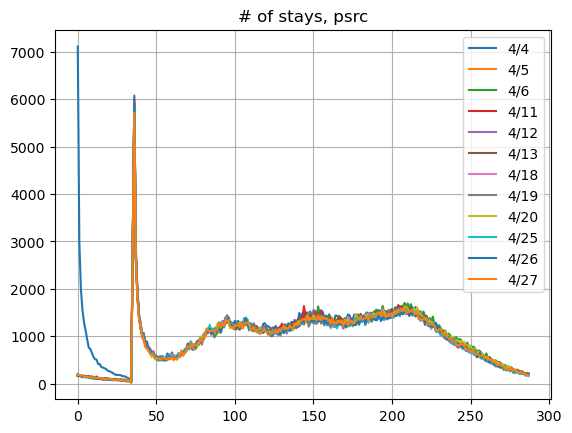

In [121]:
plt.title('# of stays, psrc')
for i in range(trip_stay_ct.shape[0]):
    plt.plot(trip_stay_ct.loc[i, 0:], label='4/'+str(trip_stay_ct.day[i]))
plt.legend()
plt.grid()

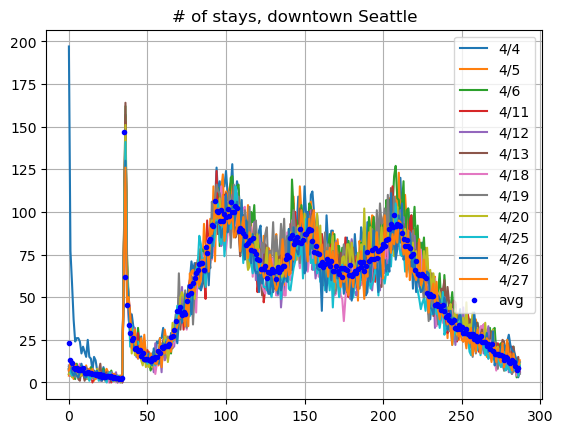

In [161]:
trip_stay_ct = trip_stay_ct.replace(np.nan, 0)
avg_val = np.sum(trip_stay_ct.loc[:, 0:].to_numpy(), axis=0)/(np.count_nonzero(trip_stay_ct.loc[:, 0:].to_numpy(), axis=0))
print('max loc', np.argmax(avg_val))
print('max value',  trip_stay_ct.loc[:, 36].values)

plt.title('# of stays, downtown Seattle')
for i in range(trip_stay_ct.shape[0]):
    plt.plot(trip_stay_ct.loc[i, 0:], label='4/'+str(trip_stay_ct.day[i]))
plt.plot(avg_val, 'b.', label='avg')
plt.legend()
plt.grid()

In [183]:
trip_stay_ct.columns

Index(['5min', 0], dtype='object')

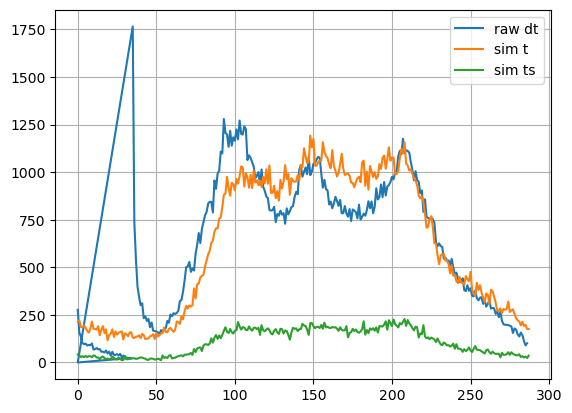

In [194]:
trip_stay_ct = trip_stay.groupby(by=['5min', 'field_1']).size().to_frame()
trip_stay_ct = trip_stay.groupby(by=['5min']).size().to_frame()
trip_stay_ct.reset_index(inplace=True)

insert_35 = pd.DataFrame([[35, 0]], columns=['5min', 0])
trip_stay_ct = pd.concat([trip_stay_ct, insert_35])
trip_stay_ct = trip_stay_ct.sort_values(by=['5min'])
plt.plot(trip_stay_ct[0], label='raw dt')

fcd_test = (fcd_dt[fcd_dt['sim_t']==1]).groupby(by=['time_5_new', 'reids']).size().to_frame()
fcd_test = fcd_test.groupby(by=['time_5_new']).size().to_frame()
plt.plot(fcd_test[0], label = 'sim t')

fcd_test = (fcd_dt[fcd_dt['sim_ts']==1]).groupby(by=['time_5_new', 'reids']).size().to_frame()
fcd_test = fcd_test.groupby(by=['time_5_new']).size().to_frame()
plt.plot(fcd_test[0], label = 'sim ts')

plt.legend()
plt.grid()

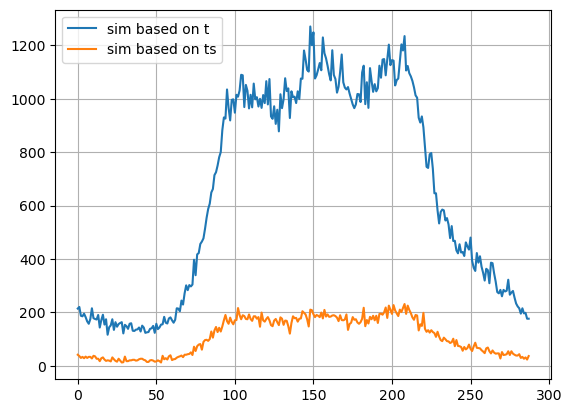

In [172]:
plt.plot(fcd_dt.groupby(by=['time_5_new']).sum()['sim_t'], label='sim based on t')
plt.plot(fcd_dt.groupby(by=['time_5_new']).sum()['sim_ts'], label='sim based on ts')
plt.legend()
plt.grid()

### NMF test

In [23]:
from sklearn.decomposition import NMF

In [225]:
def fit_dt(fcd_dt, sim_col, k_val): 
    sim_dt = getinput_mx(fcd_dt, sim_col)
    #predict data based on time
    model = NMF(n_components=k_val, init='random', random_state=0)
    W = model.fit_transform(sim_dt)
    H = model.components_
    return(np.dot(W, H))

In [226]:
#getinput_mx(fcd_dt, 'sim_ts')

In [ ]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
#fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)
fcd_dt = check_fcd_dt(fcd_dt)

In [24]:
#algorithm, nmf test
WH_ts = fit_dt01(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_ht10per_withstay01.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_100_ht10per_withstay01.csv')
del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt01(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_ht10per_withstay_01.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_ht10per_withstay_01.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay01(fcd_dt, 'sim_t', 12, 100, '100t_ht10per01')

fit_dtbytime_stay01(fcd_dt, 'sim_ts', 12, 100, '100ts_ht10per01')

C:\Users\flwang\AppData\Local\Temp\ipykernel_2196\1920398526.py:458: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcd_dt['id_index']= fcd_dt['reids'].apply(get_id_index)


(11709, 50112)


ValueError: Invalid beta_loss parameter: got 'binary_reconstruction' instead of one of dict_keys(['frobenius', 'kullback-leibler', 'itakura-saito']), or a float.

In [ ]:
#fcd_dt = pd.read_csv('fcd_dt_ht_with_stay_Seadt.csv', index_col=0)
fcd_dt = pd.read_csv('fcd_dt_all_with_stay_Seadt.csv', index_col=0)

#algorithm, nmf test
WH_ts = fit_dt01(fcd_dt, 'sim_t', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_t_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_t_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

WH_ts = fit_dt01(fcd_dt, 'sim_ts', 100)
WH_max, WH_index = get_pred_dt(WH_ts, 288)
pd.DataFrame(WH_max).to_csv('WH_max_ts_100_all10pe_withstay.csv')
pd.DataFrame(WH_index).to_csv('WH_index_ts_100_all10pe_withstay.csv')
del(WH_ts, WH_max, WH_index)

fit_dtbytime_stay01(fcd_dt, 'sim_t', 12, 100, '100t_all10pe')

fit_dtbytime_stay01(fcd_dt, 'sim_ts', 12, 100, '100ts_all10pe')

### Surprise application

In [2]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import SVDpp
from surprise import get_dataset_dir, dump
from surprise.model_selection import train_test_split
from surprise import KNNBasic, KNNWithMeans, KNNBaseline, KNNWithZScore
from surprise import NormalPredictor


In [3]:
from surprise import NMF

In [10]:
#check similarity
len(np.unique(fcd_dt['reids']))

11709

In [11]:
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(fcd_dt[['id_index', 'ts_index', 'sim_t']], 
                            reader=reader)

In [12]:
train = data.build_full_trainset()
#test = data.build_anti_testset()

In [13]:
train.n_users

11709

In [14]:
train.n_items

49052

In [272]:
algo = NormalPredictor()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)

RMSE: 0.2631


0.263052824716942

In [273]:
algo = SVD()
algo.fit(train)
predictions = algo.test(train.build_testset())
accuracy.rmse(predictions)
del(predictions)

RMSE: 0.2012


0.20116639097274144

In [281]:
algo = KNNBaseline()
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1949


0.19494840144804554

In [17]:
#similarities between items
sim_options = {'name': 'cosine',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.1554


0.15539946341857047

In [18]:
#similarities between items
sim_options = {'name': 'pearson',
              'user_based': True}

algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [19]:
#'MSD'
algo = KNNBasic(sim_options=sim_options)
algo.fit(train)

predictions_KNN = algo.test(train.build_testset())
accuracy.rmse(predictions_KNN)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1386


0.13862897242064817

In [283]:
len(predictions_KNN)

3952561

In [ ]:
#using BMF
#import numpy as np
from sklearn.decomposition import NMF

# Load the data into a Numpy array
#ratings = np.loadtxt('ratings.csv', delimiter=',')

# Create the user-item matrix
user_item_matrix = np.zeros((num_users, num_items))
for i in range(ratings.shape[0]):
    user_item_matrix[ratings[i, 0]-1, ratings[i, 1]-1] = ratings[i, 2]

# Initialize the NMF model with binary options
model = NMF(n_components=k, init='random', random_state=0, solver='cd', beta_loss='binary_reconstruction')

# Fit the model to the user-item matrix
W = model.fit_transform(user_item_matrix)
H = model.components_

# Predict the ratings for the test set
predictions = np.dot(W, H)
